In [20]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt

In [23]:
def analyze_portfolio_risk_yf(df, index_ticker='^NSEI', confidence_level=0.95, lookback='90d'):
    results = {}

    # --- 1. Update Current Values via yfinance ---
    prices = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            price = yf.Ticker(ticker).info.get('regularMarketPrice', row['Current Price'])
            prices.append(price if price else row['Current Price'])
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']

    # --- 2. Sector exposures + Concentration risk ---
    sector_exposure = df.groupby('Sector')['Current Value'].sum() / df['Current Value'].sum()
    results['sector_exposure'] = sector_exposure.sort_values(ascending=False)
    results['concentration_risk'] = (df['Current Value'].max() / df['Current Value'].sum()).round(4)
    results['largest_holding'] = df.loc[df['Current Value'].idxmax(), ['Stock Name', 'Ticker', 'Current Value']]

    # --- 3. VaR using portfolio returns ---
    returns = df['Profit/Loss (%)']
    var_level = np.percentile(returns, (1 - confidence_level) * 100)
    total_value = df['Current Value'].sum()
    results['VaR_pct'] = round(var_level, 2)
    results['VaR_inr'] = round(total_value * abs(var_level) / 100, 2)

    # --- 4. Systematic risk (Beta-based; Market exposure) ---
    # Pull index returns from yfinance
    try:
        idx_hist = yf.Ticker(index_ticker).history(period=lookback)
        idx_returns = idx_hist['Close'].pct_change().dropna()
        # For each stock/sector, estimate Beta using yfinance info
        betas = []
        for idx, row in df.iterrows():
            ticker = row['Ticker'].upper() + '.NS'
            try:
                beta = yf.Ticker(ticker).info.get('beta')
                if beta: betas.append(beta)
            except Exception:
                continue
        if betas:
            results['portfolio_beta_mean'] = round(np.mean([b for b in betas if b is not None]),2)
            results['portfolio_beta_max'] = round(np.nanmax(betas),2)
            results['portfolio_beta_min'] = round(np.nanmin(betas),2)
        else:
            results['portfolio_beta_mean'] = None
        # Systematic risk: relate portfolio VaR to index VaR/beta
        idx_var = np.percentile(idx_returns, (1 - confidence_level) * 100)
        results['index_var_pct'] = round(idx_var*100,2)
        results['systematic_risk_note'] = (
            f"Portfolio mean beta is {results['portfolio_beta_mean']}. "
            f"Index ({index_ticker}) VaR at {int(confidence_level*100)}% confidence is {results['index_var_pct']}%. "
            "Portfolio VaR may be interpreted as a blend of sector exposure, concentration, and beta sensitivity to index moves."
        )
    except Exception as e:
        results['systematic_risk_note'] = f"Market index data unavailable: {str(e)}"

    return results


In [ ]:
def scenario_analysis_yf(df, shock_dict):
    """
    Uses yfinance to fetch current prices before applying shocks.
    shock_dict: dict with Sector or All mapping to % shock, e.g. {'IT Services': -0.10, 'All': -0.05}
    Returns: dict with shocked DataFrame and new portfolio metrics.
    """
    df = df.copy()
    prices = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            price = yf.Ticker(ticker).info.get('regularMarketPrice', row['Current Price'])
            prices.append(price if price else row['Current Price'])
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']
    df['Shocked Value'] = df['Current Value']
    
    for sector, shock in shock_dict.items():
        if sector == 'All':
            df['Shocked Value'] = df['Shocked Value'] * (1 + shock)
        else:
            df.loc[df['Sector'] == sector, 'Shocked Value'] = (
                df.loc[df['Sector'] == sector, 'Shocked Value'] * (1 + shock)
            )
    total_before = df['Current Value'].sum()
    total_after = df['Shocked Value'].sum()
    impact = total_after - total_before
    impact_pct = (impact / total_before) * 100
    
    return {
        'shocked_portfolio_df': df,
        'total_value_before': total_before,
        'total_value_after': total_after,
        'portfolio_impact_inr': round(impact, 2),
        'portfolio_impact_pct': round(impact_pct, 2)
    }


In [25]:
def track_exposures_yf(df):
    """
    Returns current sector and stock allocations as percent of portfolio value,
    using latest prices from yfinance for 'Current Value'.
    df: DataFrame with Ticker, Shares Held, Sector, Stock Name columns.
    """
    # Update each stock's current price/value using yfinance
    prices = []
    for idx, row in df.iterrows():
        ticker_yf = row['Ticker'].upper() + '.NS'
        try:
            live_price = yf.Ticker(ticker_yf).info.get('regularMarketPrice')
            if live_price:
                prices.append(live_price)
            else:
                prices.append(row['Current Price'])
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']

    # Proceed with allocation calculations as before
    total_value = df['Current Value'].sum()
    sector_alloc = (df.groupby('Sector')['Current Value'].sum() / total_value * 100).sort_values(ascending=False).round(2)
    stock_alloc = (df.groupby('Stock Name')['Current Value'].sum() / total_value * 100).sort_values(ascending=False).round(2)
    return sector_alloc, stock_alloc

# Usage:
# sector_alloc, stock_alloc = track_exposures_yf(portfolio_df)
# print(sector_alloc)
# print(stock_alloc)


In [26]:
def pnl_risk_alerts_yf(df, pnl_abs_thresh=10000, pnl_pct_thresh=10, concentration_thresh=0.2, anomaly_std=2):
    """
    Generates alerts for high P&L, high loss, high position concentration, and unusual outcomes,
    using yfinance for latest prices ('Current Value' updated).
    """
    alerts = []

    # Update current price/value using yfinance
    prices = []
    for idx, row in df.iterrows():
        ticker_yf = row['Ticker'].upper() + '.NS'
        try:
            live_price = yf.Ticker(ticker_yf).info.get('regularMarketPrice')
            if live_price:
                prices.append(live_price)
            else:
                prices.append(row['Current Price'])
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']
    df['Profit/Loss (₹)'] = df['Current Value'] - df['Purchase Value']
    df['Profit/Loss (%)'] = (df['Profit/Loss (₹)'] / df['Purchase Value'] * 100).round(2)

    # Threshold-based P&L alerts
    for idx, row in df.iterrows():
        if abs(row['Profit/Loss (₹)']) > pnl_abs_thresh or abs(row['Profit/Loss (%)']) > pnl_pct_thresh:
            alerts.append(f"P&L Alert: {row['Stock Name']} ({row['Ticker']}) - P&L = {row['Profit/Loss (₹)']} (₹), {row['Profit/Loss (%)']} (%)")

    # Concentration risk alert
    total_current = df['Current Value'].sum()
    large_positions = df[df['Current Value'] > concentration_thresh * total_current]
    for idx, row in large_positions.iterrows():
        alerts.append(f"Concentration Alert: {row['Stock Name']} ({row['Ticker']}) holds {round(row['Current Value']/total_current*100,2)}% of portfolio value.")

    # Anomaly detection (Z-score for profit/loss %)
    mean_pl = df['Profit/Loss (%)'].mean()
    std_pl = df['Profit/Loss (%)'].std()
    df['pnl_zscore'] = (df['Profit/Loss (%)'] - mean_pl) / std_pl
    anomalies = df[abs(df['pnl_zscore']) > anomaly_std]
    for idx, row in anomalies.iterrows():
        alerts.append(f"Anomaly Alert: {row['Stock Name']} ({row['Ticker']}) has abnormal P&L (%) z-score: {round(row['pnl_zscore'],2)}")

    return alerts


In [8]:
def clean_portfolio_data(df):
    """
    Cleans and formats portfolio data:
      - Trims whitespace, fixes column names
      - Converts numbers to the correct type
      - Ensures Acquisition Date is datetime
      - Drops duplicates, fills NA for values
      - Lowercases ticker for consistency
    Accepts DataFrame with your specified columns
    Returns: cleaned DataFrame
    """
    # Standardize column names
    expected_cols = [
        'Client ID','Portfolio ID','Stock Name','Ticker','ISIN','Sector',
        'Shares Held','Purchase Price','Current Price','Acquisition Date',
        'Purchase Value','Current Value','Profit/Loss (₹)','Profit/Loss (%)',
        'Holding Period (days)','Holding Period (years)'
    ]
    df.columns = [c.strip() for c in df.columns]
    # Retain only expected columns
    df = df[[col for col in expected_cols if col in df.columns]]
    
    # Clean whitespace and string formatting
    df['Stock Name'] = df['Stock Name'].str.strip()
    df['Ticker'] = df['Ticker'].str.strip().str.lower()
    df['ISIN'] = df['ISIN'].str.strip()
    df['Sector'] = df['Sector'].str.strip()
    
    # Convert numeric columns
    num_cols = [
        'Shares Held','Purchase Price','Current Price',
        'Purchase Value','Current Value','Profit/Loss (₹)','Profit/Loss (%)',
        'Holding Period (days)','Holding Period (years)'
    ]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Parse dates
    if 'Acquisition Date' in df.columns:
        df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], errors='coerce')
    
    # Drop duplicate rows
    df = df.drop_duplicates()
    
    # Fill missing values for numeric columns with zero
    df[num_cols] = df[num_cols].fillna(0)
    
    # Fill missing values for text columns with blank
    text_cols = ['Client ID','Portfolio ID','Stock Name','Ticker','ISIN','Sector']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].fillna('')
    
    return df


In [10]:
def risk_profiling_dynamic(df):
    """
    Uses yfinance to fetch latest prices and Beta.
    Updates Current Price/Value dynamically.
    Calculates exposures, volatility, VaR, and includes yfinance Beta.
    """
    results = {}
    # Fetch latest prices and beta
    prices = {}
    betas = {}
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            price = info.get('regularMarketPrice')
            beta = info.get('beta')
            # Use fetched price if available
            prices[idx] = price if price else row['Current Price']
            betas[row['Ticker'].upper()] = beta
        except Exception:
            prices[idx] = row['Current Price']
            betas[row['Ticker'].upper()] = None
    
    # Update Current Price and Current Value
    df['Current Price'] = pd.Series(prices)
    df['Current Value'] = df['Shares Held'] * df['Current Price']

    total_value = df['Current Value'].sum()
    # Exposures by asset/sector
    results['asset_exposures'] = (df.set_index('Stock Name')['Current Value'] / total_value * 100).sort_values(ascending=False)
    results['sector_exposures'] = (df.groupby('Sector')['Current Value'].sum() / total_value * 100).sort_values(ascending=False)
    # Volatility from P&L % (using updated values)
    df['Profit/Loss (₹)'] = df['Current Value'] - df['Purchase Value']
    df['Profit/Loss (%)'] = (df['Profit/Loss (₹)'] / df['Purchase Value'] * 100).round(2)
    results['portfolio_volatility'] = round(df['Profit/Loss (%)'].std(), 2)
    # VaR
    confidence_level = 0.95
    var_pct = np.percentile(df['Profit/Loss (%)'], (1-confidence_level)*100)
    results['VaR_pct'] = round(var_pct, 2)
    results['VaR_value'] = round(total_value * abs(var_pct) / 100, 2)
    # Beta from yfinance
    results['stock_betas_yfinance'] = betas
    return results


In [11]:
def scenario_analysis_dynamic(df, shock_dict=None, fx_move=0):
    """
    Fetches latest prices from yfinance for all stocks.
    Applies market and sector shocks, FX move.
    Returns shocked values and impact summary.
    """
    import yfinance as yf
    prices = {}
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            price = info.get('regularMarketPrice')
            prices[idx] = price if price else row['Current Price']
        except Exception:
            prices[idx] = row['Current Price']
    # Update prices in DataFrame
    shocked_df = df.copy()
    shocked_df['Current Price'] = pd.Series(prices)
    shocked_df['Shocked Price'] = shocked_df['Current Price']

    # FX move applied to all (if any)
    if fx_move != 0:
        shocked_df['Shocked Price'] *= (1 + fx_move)

    # Sector/portfolio-wide shocks
    if shock_dict:
        for sector, pct in shock_dict.items():
            if sector == 'All':
                shocked_df.loc[:, 'Shocked Price'] *= (1 + pct)
            else:
                shocked_df.loc[shocked_df['Sector'] == sector, 'Shocked Price'] *= (1 + pct)

    # Recalculate shocked values and P&L
    shocked_df['Shocked Value'] = shocked_df['Shares Held'] * shocked_df['Shocked Price']
    shocked_df['Shocked Profit/Loss (₹)'] = shocked_df['Shocked Value'] - shocked_df['Purchase Value']
    shocked_df['Shocked Profit/Loss (%)'] = (shocked_df['Shocked Profit/Loss (₹)'] / shocked_df['Purchase Value'] * 100).round(2)

    before = df['Current Value'].sum()
    after = shocked_df['Shocked Value'].sum()
    summary = {
        'total_before': before,
        'total_after': after,
        'impact_inr': round(after - before, 2),
        'impact_pct': round((after/before - 1)*100, 2)
    }
    return shocked_df, summary


In [12]:
def visualize_exposures_yf(df):
    """
    Updates 'Current Price' and 'Current Value' dynamically using yfinance,
    then visualizes sector and asset allocations (pie charts).
    """
    prices = []
    for idx, row in df.iterrows():
        ticker_yf = row['Ticker'].upper() + '.NS'
        try:
            stock = yf.Ticker(ticker_yf)
            info = stock.info
            prices.append(info.get('regularMarketPrice', row['Current Price']))
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']
    total_value = df['Current Value'].sum()
    
    # Sector allocation pie chart
    sector_alloc = (df.groupby('Sector')['Current Value'].sum() / total_value)
    sector_alloc.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
    plt.title('Portfolio Sector Allocation (Live)')
    plt.ylabel('')
    plt.show()
    
    # Asset allocation pie chart
    asset_alloc = (df.set_index('Stock Name')['Current Value'] / total_value)
    asset_alloc.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
    plt.title('Portfolio Asset Allocation (Live)')
    plt.ylabel('')
    plt.show()
    
    # Track and print top exposures
    top_sectors = sector_alloc.sort_values(ascending=False).head(3)
    top_assets = asset_alloc.sort_values(ascending=False).head(3)
    print('Top Sector Exposures:\n', top_sectors)
    print('Top Asset Exposures:\n', top_assets)



In [13]:
def time_series_exposure_yf(df_list, date_labels):
    """
    df_list: list of portfolio DataFrames (one per date)
    date_labels: corresponding date labels
    Dynamically updates exposure allocations over time from yfinance prices.
    Visualizes as time series.
    """
    sector_time_series = {}
    for df, date in zip(df_list, date_labels):
        prices = []
        for idx, row in df.iterrows():
            ticker_yf = row['Ticker'].upper() + '.NS'
            try:
                stock = yf.Ticker(ticker_yf)
                info = stock.info
                prices.append(info.get('regularMarketPrice', row['Current Price']))
            except Exception:
                prices.append(row['Current Price'])
        df['Current Price'] = prices
        df['Current Value'] = df['Shares Held'] * df['Current Price']
        total_value = df['Current Value'].sum()
        alloc = (df.groupby('Sector')['Current Value'].sum() / total_value)
        for sector in alloc.index:
            sector_time_series.setdefault(sector, []).append(alloc[sector])
    # Plot as time series
    for sector, allocations in sector_time_series.items():
        plt.plot(date_labels, allocations, label=sector)
    plt.title("Sector Allocation Over Time (Live)")
    plt.xlabel("Date")
    plt.ylabel("Allocation %")
    plt.legend()
    plt.show()


In [14]:
def plot_exposure_allocations_yf(df):
    """
    Update 'Current Price' and 'Current Value' using yfinance,
    then plot sector and asset allocations as pie charts.
    """
    # Update prices dynamically
    prices = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            live_price = yf.Ticker(ticker).info.get('regularMarketPrice')
            prices.append(live_price if live_price else row['Current Price'])
        except Exception:
            prices.append(row['Current Price'])
    df['Current Price'] = prices
    df['Current Value'] = df['Shares Held'] * df['Current Price']
    total_value = df['Current Value'].sum()

    # Pie chart for sector allocations
    sector_alloc = (df.groupby('Sector')['Current Value'].sum() / total_value)
    sector_alloc.plot.pie(autopct='%1.1f%%', figsize=(6,6), title='Live Sector Allocation')
    plt.ylabel('')
    plt.show()

    # Pie chart for asset allocations
    asset_alloc = (df.set_index('Stock Name')['Current Value'] / total_value)
    asset_alloc.plot.pie(autopct='%1.1f%%', figsize=(6,6), title='Live Stock Allocation')
    plt.ylabel('')
    plt.show()

    # Track top exposures
    top_sectors = sector_alloc.sort_values(ascending=False).head(3)
    top_assets = asset_alloc.sort_values(ascending=False).head(3)
    print('Top Sector Exposures:\n', top_sectors)
    print('Top Holdings:\n', top_assets)


In [21]:
def pnl_risk_alerts_yf(df, pnl_abs_thresh=10000, pnl_pct_thresh=5, var_thresh=0.05, vol_thresh=0.03, lookback='7d'):
    """
    Compares daily/weekly (defined by lookback) P&L to thresholds, computes VaR and realized volatility.
    Triggers alerts for large moves using yfinance for price history.
    """
    alerts = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            # Get historical price for lookback period
            hist = yf.Ticker(ticker).history(period=lookback)
            if len(hist) < 2:
                continue  # not enough data
            current_price = hist['Close'][-1]
            past_price = hist['Close'][0]
            returns = hist['Close'].pct_change().dropna()
            realized_vol = returns.std()
            var_5 = np.percentile(returns, 5)
            # Compute portfolio P&L over lookback
            pnl_abs = (current_price - past_price) * row['Shares Held']
            pnl_pct = (current_price - past_price) / past_price * 100
            # Check threshold alerts
            if abs(pnl_abs) > pnl_abs_thresh or abs(pnl_pct) > pnl_pct_thresh:
                alerts.append(
                    f"{row['Stock Name']} ({row['Ticker']}): {lookback} P&L alert: ₹{int(pnl_abs)} ({round(pnl_pct,2)}%)")
            # Var and realized vol risk alerts
            if abs(var_5) > var_thresh:
                alerts.append(
                    f"{row['Stock Name']} ({row['Ticker']}): VaR alert! 5th percentile return = {round(var_5*100,2)}%")
            if realized_vol > vol_thresh:
                alerts.append(
                    f"{row['Stock Name']} ({row['Ticker']}): Volatility alert! Realized vol = {round(realized_vol*100,2)}%")
        except Exception:
            continue
    return alerts

# Example usage:
# alerts = pnl_risk_alerts_yf(portfolio_df)
# for alert in alerts: print(alert)


In [22]:
def hourly_portfolio_scan(df, pnl_abs_thresh=10000, pnl_pct_thresh=2, lookback='60m'):
    """
    Runs an hourly scan for large P&L/risk moves, using latest intraday prices from yfinance.
    Arguments:
      pnl_abs_thresh: absolute ₹ threshold for alert
      pnl_pct_thresh: percent threshold for alert
      lookback: intraday interval (e.g., '60m' for 1 hour back)
    Returns:
      alerts: list of alert strings
      report_df: DataFrame of latest scan result
    """
    alerts = []
    report_rows = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            # Get most recent hour's data
            hist = yf.Ticker(ticker).history(period='2h', interval='15m')
            if len(hist) < 2:
                continue
            now_price = hist['Close'][-1]
            hour_ago_price = hist['Close'][-4]  # 4 intervals of 15m = 1 hour ago
            pnl_abs = (now_price - hour_ago_price) * row['Shares Held']
            pnl_pct = (now_price - hour_ago_price) / hour_ago_price * 100
            # Trigger alert if above threshold
            if abs(pnl_abs) > pnl_abs_thresh or abs(pnl_pct) > pnl_pct_thresh:
                alerts.append(f"Hourly Alert: {row['Stock Name']} ({row['Ticker']}): ₹{int(pnl_abs)} ({round(pnl_pct,2)}%)")
            # Add to report
            report_rows.append({
                'Time': datetime.now().strftime('%Y-%m-%d %H:%M'),
                'Stock Name': row['Stock Name'],
                'Ticker': row['Ticker'],
                'Shares Held': row['Shares Held'],
                'Price 1 Hour Ago': hour_ago_price,
                'Now Price': now_price,
                'P&L (₹)': pnl_abs,
                'P&L (%)': pnl_pct
            })
        except Exception as e:
            continue
    report_df = pd.DataFrame(report_rows)
    return alerts, report_df

# Example usage:
# alerts, report_df = hourly_portfolio_scan(portfolio_df)
# print(alerts)
# report_df.to_csv(f'portfolio_hourly_report_{datetime.now().strftime('%Y%m%d_%H%M')}.csv', index=False)


In [17]:
from datetime import datetime

def daily_portfolio_scan(df, pnl_abs_thresh=10000, pnl_pct_thresh=5, lookback='1d'):
    alerts = []
    report_rows = []
    for idx, row in df.iterrows():
        ticker = row['Ticker'].upper() + '.NS'
        try:
            hist = yf.Ticker(ticker).history(period=lookback)
            if len(hist) < 2: continue
            today_price = hist['Close'][-1]
            yesterday_price = hist['Close'][0]
            pnl_abs = (today_price - yesterday_price) * row['Shares Held']
            pnl_pct = (today_price - yesterday_price) / yesterday_price * 100
            # Alert logic
            if abs(pnl_abs) > pnl_abs_thresh or abs(pnl_pct) > pnl_pct_thresh:
                alerts.append(f"Change: {row['Stock Name']} ({row['Ticker']}) | P&L ₹{int(pnl_abs)} ({round(pnl_pct,2)}%)")
            # Add to report
            report_rows.append({
                'Date': datetime.now().date(),
                'Stock Name': row['Stock Name'],
                'Ticker': row['Ticker'],
                'Shares Held': row['Shares Held'],
                'Yesterday Price': yesterday_price,
                'Today Price': today_price,
                'P&L(₹)': pnl_abs,
                'P&L(%)': pnl_pct
            })
        except Exception:
            continue
    # Report DataFrame
    report_df = pd.DataFrame(report_rows)
    return alerts, report_df

# Example usage
# portfolio_df = pd.read_csv('in_depth_sample_portfolio.csv')
# alerts, report = daily_portfolio_scan(portfolio_df)
# print(alerts)
# report.to_csv(f'portfolio_daily_report_{datetime.now().date()}.csv', index=False)



=== Basic Portfolio Risk Analysis ===
Sector Exposures:
Sector
IT Services         0.345384
Automobile          0.190278
FMCG                0.114587
Banking/Finance     0.105865
Pharma              0.085566
Chemicals/Paints    0.060931
FMCG/Tobacco        0.035144
Energy/Telecom      0.027135
Telecom             0.025562
Infrastructure      0.009548
Name: Current Value, dtype: float64

Concentration Risk: 0.1312
Largest Holding: Stock Name        Wipro Ltd
Ticker                wipro
Current Value    1230715.22
Name: 36, dtype: object
VaR (%): -8.45%
VaR (₹): 792218.95

=== Live Portfolio Risk Analysis ===
Updated Portfolio Beta: 0.36
Portfolio mean beta is 0.36. Index (^NSEI) VaR at 95% confidence is -0.89%. Portfolio VaR may be interpreted as a blend of sector exposure, concentration, and beta sensitivity to index moves.

=== Scenario Analysis Results ===
Portfolio Impact (₹): -1011961.78
Portfolio Impact (%): -5.67%

=== Current Portfolio Exposures ===
Sector Allocation:
 Sector
A

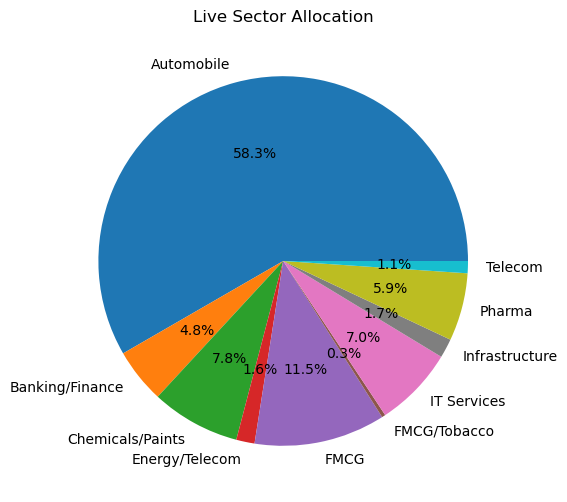

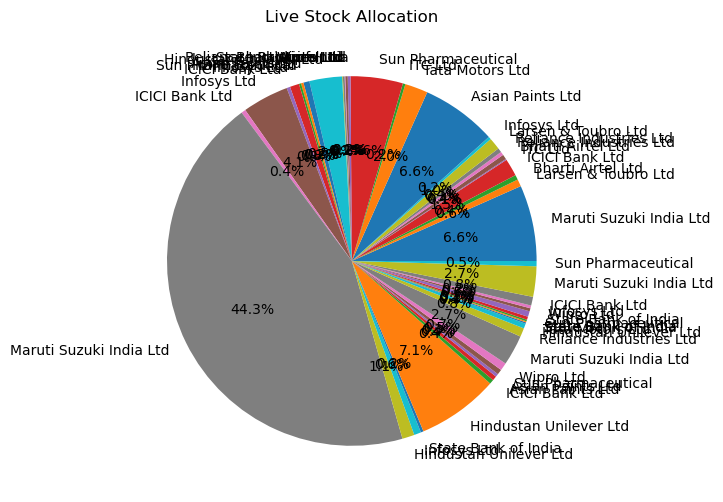

Top Sector Exposures:
 Sector
Automobile          0.583309
FMCG                0.114723
Chemicals/Paints    0.077901
Name: Current Value, dtype: float64
Top Holdings:
 Stock Name
Maruti Suzuki India Ltd    0.442563
Hindustan Unilever Ltd     0.071256
Maruti Suzuki India Ltd    0.066384
Name: Current Value, dtype: float64

=== Daily Portfolio Scan ===


In [29]:
# Read the portfolio data
df = pd.read_csv('mock_portfolio_data.csv')

# Clean the data
df = clean_portfolio_data(df)

# 1. Run basic portfolio risk analysis
risk_results = analyze_portfolio_risk(df)
print("\n=== Basic Portfolio Risk Analysis ===")
print(f"Sector Exposures:\n{risk_results['sector_exposure']}")
print(f"\nConcentration Risk: {risk_results['concentration_risk']}")
print(f"Largest Holding: {risk_results['largest_holding']}")
print(f"VaR (%): {risk_results['VaR_pct']}%")
print(f"VaR (₹): {risk_results['VaR_inr']}")

# 2. Run dynamic risk analysis with live data
risk_results_live = analyze_portfolio_risk_yf(df)
print("\n=== Live Portfolio Risk Analysis ===")
print(f"Updated Portfolio Beta: {risk_results_live.get('portfolio_beta_mean', 'N/A')}")
print(risk_results_live.get('systematic_risk_note', 'Market data unavailable'))

# 3. Run scenario analysis
shock_scenarios = {
    'All': -0.05,  # 5% market-wide shock
    'IT Services': -0.10  # 10% IT sector shock
}
scenario_results = scenario_analysis_yf(df, shock_scenarios)
print("\n=== Scenario Analysis Results ===")
print(f"Portfolio Impact (₹): {scenario_results['portfolio_impact_inr']}")
print(f"Portfolio Impact (%): {scenario_results['portfolio_impact_pct']}%")

# 4. Track current exposures
sector_alloc, stock_alloc = track_exposures_yf(df)
print("\n=== Current Portfolio Exposures ===")
print("Sector Allocation:\n", sector_alloc)
print("\nStock Allocation:\n", stock_alloc)

# 5. Generate risk alerts
alerts = pnl_risk_alerts_yf(df)
print("\n=== Risk Alerts ===")
for alert in alerts:
    print(alert)

# 6. Visualize portfolio allocations
plot_exposure_allocations_yf(df)

# 7. Run daily portfolio scan
daily_alerts, daily_report = daily_portfolio_scan(df)
print("\n=== Daily Portfolio Scan ===")
for alert in daily_alerts:
    print(alert)


In [30]:

def visualize_portfolio_human(df):
    """
    Plots a dashboard: sector exposure (pie), holdings (bar), stock-wise P&L (bar, colored), summary risk alert (emoji)
    """
    # --- Sectors pie chart ---
    plt.figure(figsize=(16, 12))
    plt.subplot(2,2,1)
    sector_alloc = (df.groupby('Sector')['Current Value'].sum() / df['Current Value'].sum())
    sector_alloc = sector_alloc[sector_alloc > 0.01]  # Show sectors >1%, group others
    sector_alloc.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
    plt.title("Where Is My Money? (By Sector)")

    # --- Top holdings bar chart ---
    plt.subplot(2,2,2)
    holding_alloc = (df.groupby('Stock Name')['Current Value'].sum() / df['Current Value'].sum()).sort_values(ascending=False).head(10)
    holding_alloc.plot(kind='bar', color='skyblue')
    plt.title('Top 10 Holdings – Who Really Matters')
    plt.ylabel('Allocation (%)')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

    # --- Stockwise P&L: green=profit, red=loss ---
    plt.subplot(2,2,3)
    df['Profit/Loss (₹)'] = df['Current Value'] - df['Purchase Value']
    pl = df.groupby('Stock Name')['Profit/Loss (₹)'].sum().sort_values()
    colors = ['crimson' if v < 0 else 'green' for v in pl]
    pl.plot(kind='barh', color=colors)
    plt.title('Profit Or Loss? (Stockwise)')
    plt.xlabel('Net Profit/Loss (₹)')
    plt.axvline(0, color='black', linestyle='--')

    # --- Risk summary / visual: Smileys, warnings ---
    plt.subplot(2,2,4)
    total_pl = df['Profit/Loss (₹)'].sum()
    profit = total_pl > 0
    biggest_concentration = (df['Current Value'].max() / df['Current Value'].sum())
    # Risk: Highly concentrated + negative = VERY BAD, etc.
    if profit and biggest_concentration < 0.3:
        icon = "😀"
        status = "Strong Portfolio: Making money, well diversified"
    elif profit:
        icon = "🙂"
        status = "Caution: Profitable, but a bit concentrated"
    elif not profit and biggest_concentration < 0.3:
        icon = "😐"
        status = "Losses, but not too concentrated. Consider adjustments"
    else:
        icon = "😱"
        status = "Major Risk: Losses & too much in 1–2 stocks!"

    plt.axis('off')
    plt.text(0.5, 0.6, icon, fontsize=90, ha='center')
    plt.text(0.5, 0.38, status, fontsize=16, ha='center', wrap=True)
    summary = f"Total Portfolio P&L: {'₹{:,.0f}'.format(total_pl)}\nLargest holding: {round(biggest_concentration*100,1)}% of value"
    plt.text(0.5, 0.18, summary, fontsize=13, ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.suptitle("📊 Is This Portfolio Good For Me? – Simple Dashboard", size=22, fontweight='bold')
    plt.show()


C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_29252\3983206649.py:57: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


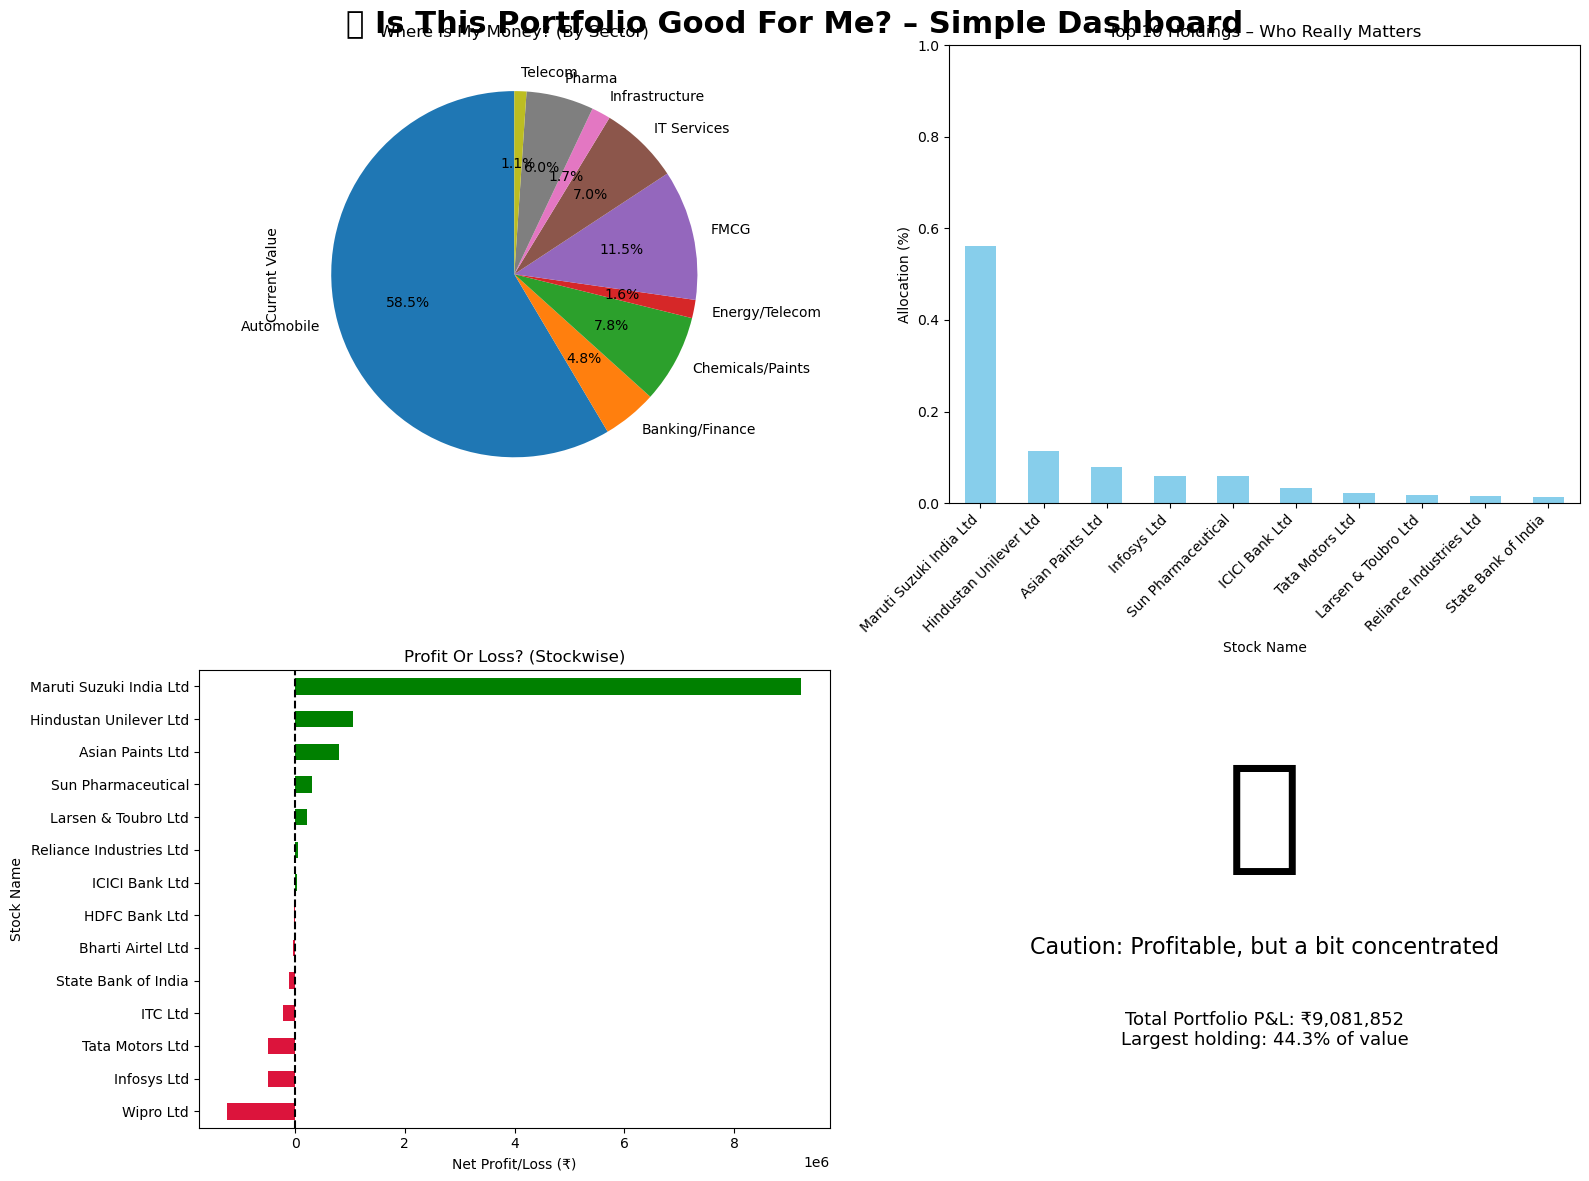

In [31]:
visualize_portfolio_human(df)


In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_everything(df, risk_results, scenario_results, sector_alloc, stock_alloc, alerts):
    """
    Make a 2x2 'dashboard':
      1. Pie (sector allocation)
      2. Pie (top holdings)
      3. Bar (P&L for each stock, color: green=profit/red=loss)
      4. Smile/warning with key metrics, concentration, scenario result, and big-risk alerts
    """
    # Pie chart for sector allocation
    plt.figure(figsize=(14,10))

    plt.subplot(2,2,1)
    sector_alloc[sector_alloc>0].plot.pie(autopct='%1.0f%%', startangle=90)
    plt.title("Where's my money? (Sectors)")

    plt.subplot(2,2,2)
    (stock_alloc[stock_alloc>0].head(8)).plot.pie(autopct='%1.0f%%', startangle=90, legend=False)
    plt.title("What's my biggest bet? (Top Holdings)")

    # Bar for P&L by stock
    plt.subplot(2,2,3)
    df['Profit/Loss (₹)'] = df['Current Value'] - df['Purchase Value']
    df_pl = df.groupby('Stock Name')['Profit/Loss (₹)'].sum().sort_values()
    colors = ["crimson" if v<0 else "seagreen" for v in df_pl]
    df_pl.plot(kind='barh', color=colors)
    plt.title("Am I making money? (Profit/Loss per Stock)")
    plt.xlabel("Net ₹ P&L")

    # Ultra-dumb dashboard: smiley or warning and summary
    plt.subplot(2,2,4)
    total_pl = df['Profit/Loss (₹)'].sum()
    percent_pl = round(total_pl/df['Purchase Value'].sum()*100, 1)
    concentration = risk_results['concentration_risk']
    warning = "GOOD 😊"
    warning_color = "forestgreen"
    if percent_pl < 0 or concentration > 0.3:
        warning = "BAD! 😱" if percent_pl < 0 and concentration > 0.3 else "WARNING ⚠️"
        warning_color = "crimson"
    plt.axis("off")
    plt.text(0.5, 0.8, warning, fontsize=48, ha='center', color=warning_color)
    rest = f"Total P&L: ₹{int(total_pl):,} ({percent_pl}%)\nLargest stock: {int(concentration*100)}%\nPortfolio scenario impact: {scenario_results['portfolio_impact_pct']}% \n\nAlerts:\n" + (',\n'.join(alerts[:3]) + ("..." if len(alerts)>3 else "") if alerts else "No major alerts")
    plt.text(0.5, 0.2, rest, fontsize=13, ha='center', wrap=True)
    plt.title("Should I worry?", loc='center', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.suptitle("My Portfolio: Is It Good Or Bad?", fontsize=24, weight='bold')

    plt.show()


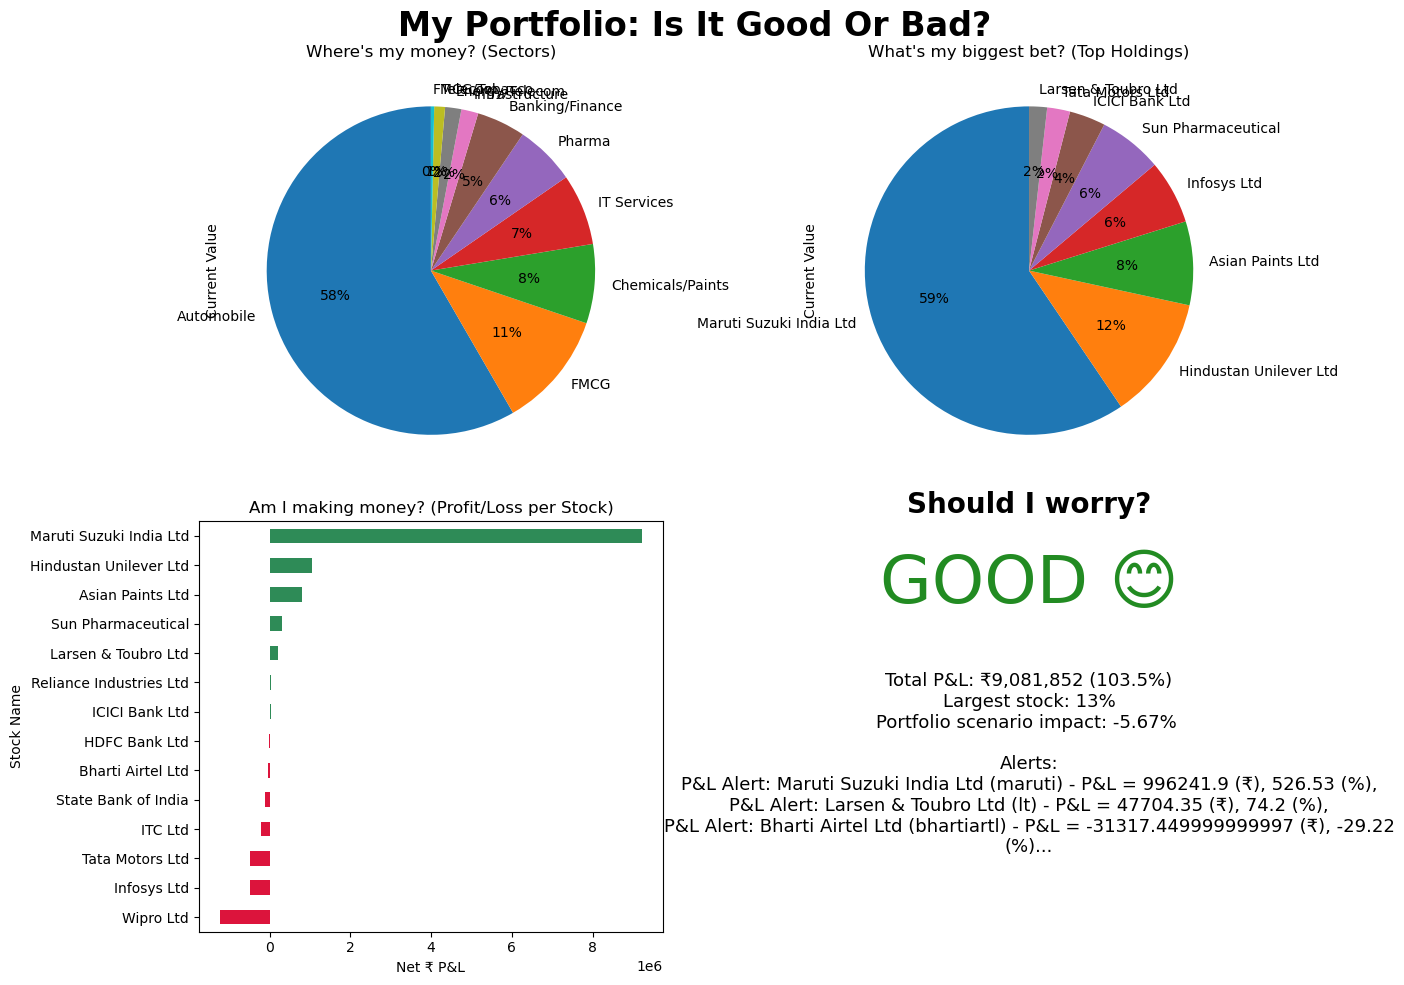

In [33]:
visualize_everything(df, risk_results, scenario_results, sector_alloc, stock_alloc, alerts)


C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_29252\2222605147.py:159: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_29252\2222605147.py:159: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_29252\2222605147.py:159: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramD

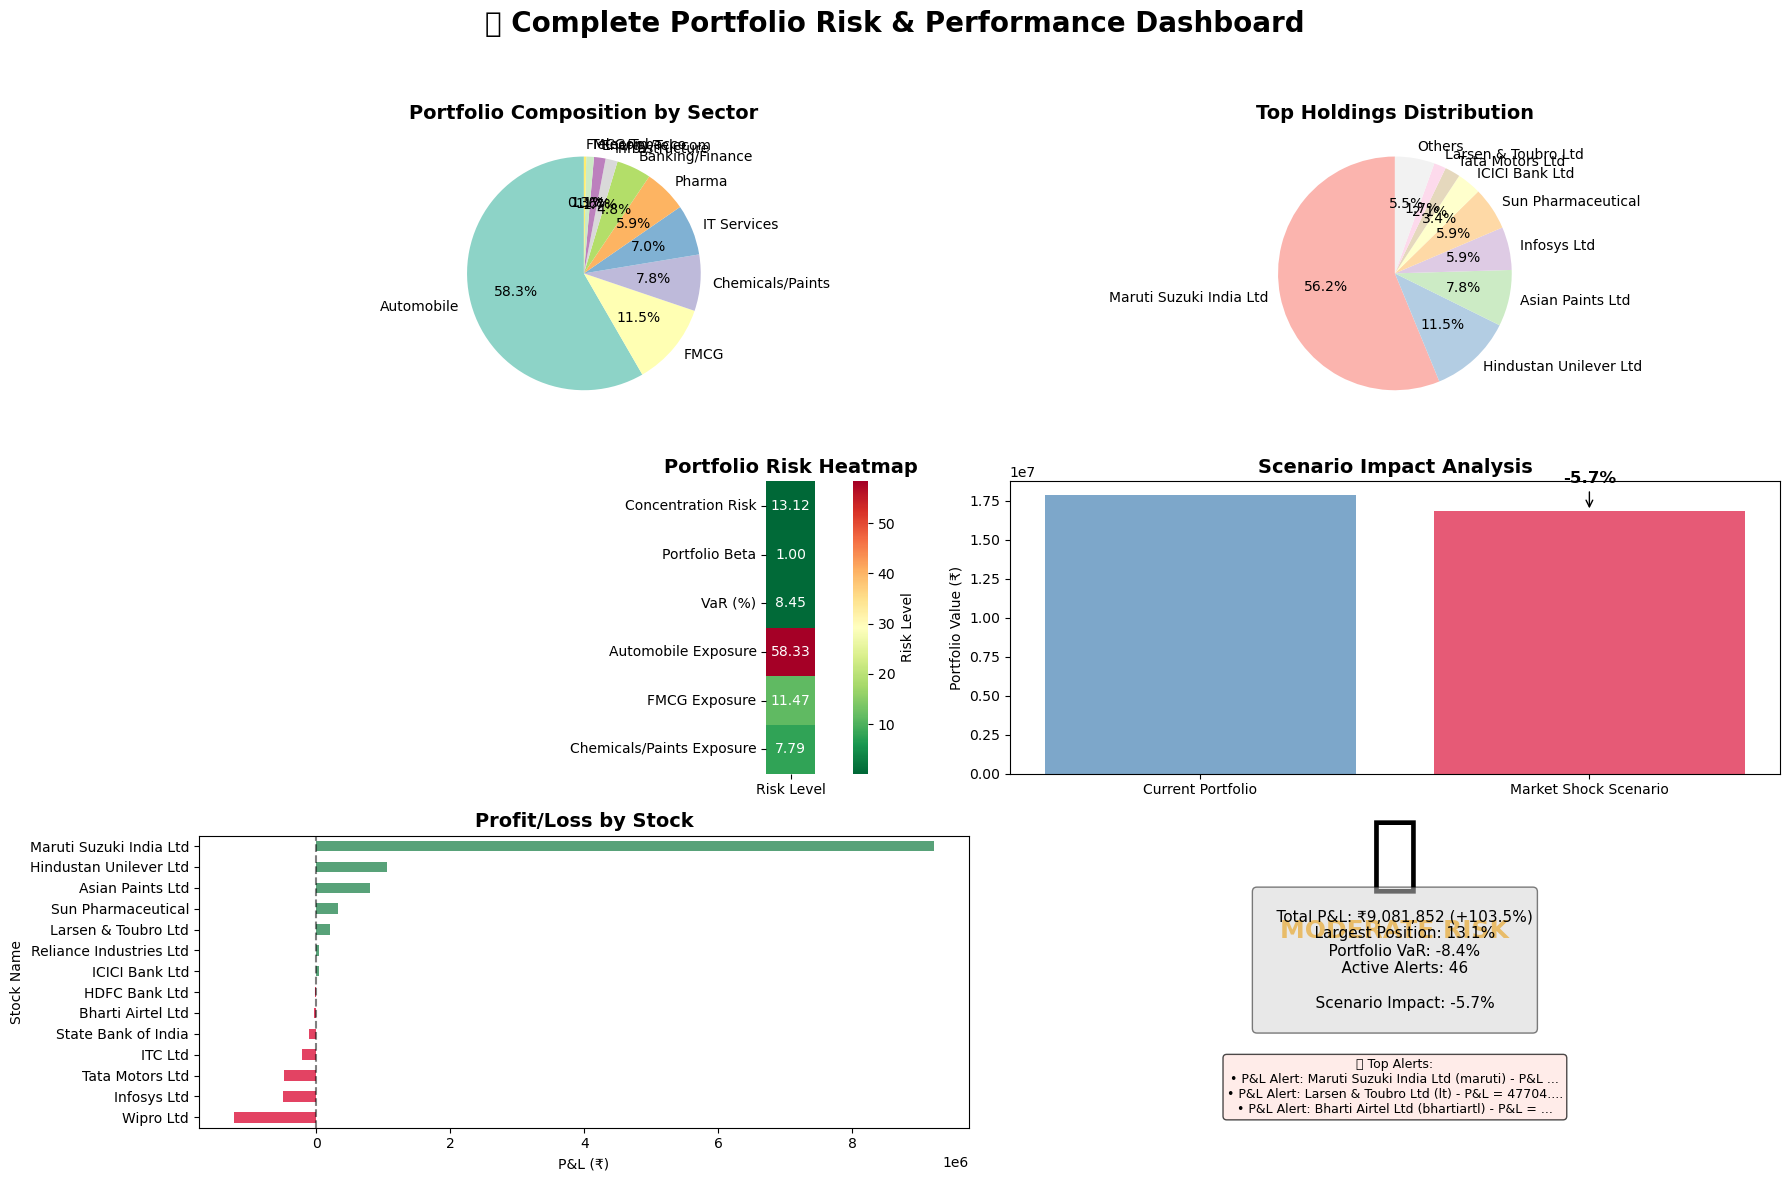

In [34]:

def create_complete_portfolio_dashboard(df, risk_results, scenario_results, sector_alloc, stock_alloc, alerts):
    """
    Creates a comprehensive 3x2 dashboard with:
    1. Sector composition pie chart
    2. Top holdings pie chart
    3. Risk heatmap (concentration, beta, VaR)
    4. Scenario impact bar chart
    5. P&L performance by stock
    6. Alert summary with emoji status
    """
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Sector Composition Pie Chart
    plt.subplot(3, 2, 1)
    colors = plt.cm.Set3(np.linspace(0, 1, len(sector_alloc)))
    sector_alloc[sector_alloc > 0].plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors,
        legend=False
    )
    plt.title("Portfolio Composition by Sector", fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    # 2. Top Holdings Pie Chart
    plt.subplot(3, 2, 2)
    top_holdings = stock_alloc.head(8)
    other_holdings = 100 - top_holdings.sum()
    if other_holdings > 0:
        top_holdings['Others'] = other_holdings
    
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(top_holdings)))
    top_holdings.plot.pie(
        autopct='%1.1f%%', 
        startangle=90,
        colors=colors,
        legend=False
    )
    plt.title("Top Holdings Distribution", fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    # 3. Risk Heatmap
    plt.subplot(3, 2, 3)
    # Create risk matrix
    risk_data = {
        'Concentration Risk': [risk_results['concentration_risk'] * 100],
        'Portfolio Beta': [risk_results.get('portfolio_beta_mean', 1.0) or 1.0],
        'VaR (%)': [abs(risk_results['VaR_pct'])],
    }
    
    # Add sector-wise concentration
    for sector in sector_alloc.head(3).index:
        risk_data[f'{sector} Exposure'] = [sector_alloc[sector]]
    
    risk_df = pd.DataFrame(risk_data).T
    risk_df.columns = ['Risk Level']
    
    # Normalize risk levels for heatmap (0-1 scale)
    risk_normalized = risk_df.copy()
    risk_normalized.loc['Concentration Risk'] = risk_normalized.loc['Concentration Risk'] / 100
    risk_normalized.loc['Portfolio Beta'] = min(risk_normalized.loc['Portfolio Beta'].iloc[0] / 2, 1)
    risk_normalized.loc['VaR (%)'] = min(risk_normalized.loc['VaR (%)'].iloc[0] / 20, 1)
    
    sns.heatmap(
        risk_normalized, 
        annot=risk_df, 
        fmt='.2f',
        cmap='RdYlGn_r',
        cbar_kws={'label': 'Risk Level'},
        square=True
    )
    plt.title("Portfolio Risk Heatmap", fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    # 4. Scenario Impact Bar Chart
    plt.subplot(3, 2, 4)
    scenarios = ['Current Portfolio', 'Market Shock Scenario']
    values = [scenario_results['total_value_before'], scenario_results['total_value_after']]
    impact = scenario_results['portfolio_impact_pct']
    
    colors = ['steelblue', 'crimson' if impact < 0 else 'seagreen']
    bars = plt.bar(scenarios, values, color=colors, alpha=0.7)
    
    # Add impact annotation
    plt.annotate(f'{impact:+.1f}%', 
                xy=(1, values[1]), 
                xytext=(1, values[1] + (values[0] * 0.1)),
                ha='center', fontsize=12, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.title("Scenario Impact Analysis", fontsize=14, fontweight='bold')
    plt.ylabel("Portfolio Value (₹)")
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 5. P&L Performance by Stock
    plt.subplot(3, 2, 5)
    df['Profit/Loss (₹)'] = df['Current Value'] - df['Purchase Value']
    stock_pl = df.groupby('Stock Name')['Profit/Loss (₹)'].sum().sort_values()
    
    colors = ['crimson' if x < 0 else 'seagreen' for x in stock_pl.values]
    stock_pl.plot(kind='barh', color=colors, alpha=0.8)
    plt.title("Profit/Loss by Stock", fontsize=14, fontweight='bold')
    plt.xlabel("P&L (₹)")
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # 6. Alert Summary with Status
    plt.subplot(3, 2, 6)
    plt.axis('off')
    
    # Calculate overall portfolio health
    total_pl = df['Profit/Loss (₹)'].sum()
    pl_pct = (total_pl / df['Purchase Value'].sum()) * 100
    concentration = risk_results['concentration_risk']
    num_alerts = len(alerts)
    
    # Determine status
    if pl_pct > 5 and concentration < 0.3 and num_alerts < 5:
        status_emoji = "🟢"
        status_text = "HEALTHY PORTFOLIO"
        status_color = "green"
    elif pl_pct > 0 and concentration < 0.5:
        status_emoji = "🟡"
        status_text = "MODERATE RISK"
        status_color = "orange"
    else:
        status_emoji = "🔴"
        status_text = "HIGH RISK"
        status_color = "red"
    
    # Display status
    plt.text(0.5, 0.85, status_emoji, fontsize=60, ha='center')
    plt.text(0.5, 0.65, status_text, fontsize=18, ha='center', 
             color=status_color, fontweight='bold')
    
    # Key metrics
    metrics_text = f"""
    Total P&L: ₹{total_pl:,.0f} ({pl_pct:+.1f}%)
    Largest Position: {concentration*100:.1f}%
    Portfolio VaR: {risk_results['VaR_pct']:.1f}%
    Active Alerts: {num_alerts}
    
    Scenario Impact: {scenario_results['portfolio_impact_pct']:+.1f}%
    """
    
    plt.text(0.5, 0.35, metrics_text, fontsize=11, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    # Top 3 alerts
    if alerts:
        alert_text = "🚨 Top Alerts:\n" + "\n".join([
            f"• {alert[:50]}..." if len(alert) > 50 else f"• {alert}" 
            for alert in alerts[:3]
        ])
        plt.text(0.5, 0.05, alert_text, fontsize=9, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="mistyrose", alpha=0.7))
    
    plt.suptitle("📊 Complete Portfolio Risk & Performance Dashboard", 
                 fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Usage example:
create_complete_portfolio_dashboard(df, risk_results, scenario_results, sector_alloc, stock_alloc, alerts)
